In [1]:
%matplotlib inline 
import ParserCACM
from Parser import Parser
from porter import stem
from ParserCACM import ParserCACM

In [3]:
import numpy as np
from irmodel import *
from weighter import *
from index import *

In [4]:
from Parser import Parser
from Document import Document
#===============================================================================
# /**
#  * 
#  * Format of input files :
#  * .I <id>
#  * .A <Author>
#  * .W
#  * <Text>

#===============================================================================
class QueryParser(Parser):
    def __init__(self):
        '''
        Constructor
        '''
        Parser.__init__(self,".I")
    
    def getDocument(self,text):
        other={};
        modeA=False;
        modeW=False;
        info=""
        identifier=""
        author=""
        texte=""
        
        st=text.split("\n");
        s=""
        for s in st:
            if(s.startswith(".I")):
                identifier=s[3:]
                continue
            
            if(s.startswith(".")):
                if(modeW):
                    texte=info
                    info=""
                    modeW=False
                
                if(modeA):
                    author=info
                    info=""
                    modeA=False;         
            
            if(s.startswith(".W")):
                modeW=True;
                info=s[2:];
                continue;
            
            if(s.startswith(".A")):
                modeA=True;
                info=s[2:];
                continue;
            
            if((modeW) or (modeA)):
                #print "add "+s
                info+=" "+s
               
    
        if(modeW):
            texte=info;
            info="";
            modeW=False;
        
        if(modeA):
            author=info;
            info="";
            modeA=False;

        other["text"]=texte[4:]
        doc=Document(identifier,texte[2:],other);
        return doc      

In [13]:
class Query():
    def __init__(self,id,text,relevants):
        self.id=id
        self.text=text
        self.relevants=relevants  
class QueryCACM(QueryParser):
    def __init__(self):
        QueryParser.__init__(self)
    def relevants(self):        
#       creat relevants
        f=open("cacm/cacm.rel")
        a={}
        for i in f:
            if i[0]=="0":
                key=i[1]
            else:
                key=i[:2]
            if a.has_key(key):
                a[key].append([i[j:7] for j in [3,4,5,6] if i[j]!="0"][0]) 
            else:
                a[key]=[[i[j:7] for j in [3,4,5,6] if i[j]!="0"][0]]
        self.relevants=a
        return self
    def nextQuery(self):
        doc=self.Q.nextDocument()       
        return Query(doc.getId(),doc.getText(),self.relevants[doc.getId()])
    def Querycacm(self):
        qp=QueryParser()
        qp.initFile("cacm/cacm.qry")
        query=qp.nextDocument()
        
        self.queries={}
        while query is not None:
            if query.getId() in self.relevants.keys():
                self.queries[query.getId()]=Query(query.getId(),query.getText(),self.relevants[query.getId()])
            else:
                self.queries[query.getId()]=Query(query.getId(),query.getText(),None)                
            query=qp.nextDocument()
        return self.queries              

In [14]:
gq=QueryCACM()
gq.relevants()
gq.Querycacm()

{'1': <__main__.Query instance at 0x10a9813f8>,
 '10': <__main__.Query instance at 0x10a8aea70>,
 '11': <__main__.Query instance at 0x10a8ae998>,
 '12': <__main__.Query instance at 0x10a8ae9e0>,
 '13': <__main__.Query instance at 0x10a8ae8c0>,
 '14': <__main__.Query instance at 0x10a9a2908>,
 '15': <__main__.Query instance at 0x10a9a2878>,
 '16': <__main__.Query instance at 0x10a9a27e8>,
 '17': <__main__.Query instance at 0x10a9a2830>,
 '18': <__main__.Query instance at 0x10a9a29e0>,
 '19': <__main__.Query instance at 0x10a9a2ab8>,
 '2': <__main__.Query instance at 0x10a97df38>,
 '20': <__main__.Query instance at 0x10a9a2b48>,
 '21': <__main__.Query instance at 0x10a9a2998>,
 '22': <__main__.Query instance at 0x10a9a2c20>,
 '23': <__main__.Query instance at 0x10a9a2950>,
 '24': <__main__.Query instance at 0x10a9a2b00>,
 '25': <__main__.Query instance at 0x10a9ac320>,
 '26': <__main__.Query instance at 0x10a9ac368>,
 '27': <__main__.Query instance at 0x10a9aca70>,
 '28': <__main__.Query

In [6]:
###  querty 里保存了所有query 包括有或者正确relevents的query  如果没有 relevents 就是None

In [7]:
# query is an objet
class IRList:
    def __init__(self,query,doc_score):
        self.query=query
        self.doc_score=doc_score
    

In [8]:
class EvalMeasure:
    def __init__(self):
        return
    def eval(self,irlist):
        raise NotImplementedError('always abstract class')
class PrecisionRecall(EvalMeasure):
#     nbLevels is a number not a rate
    def __init__(self,nbLevels=10):
        self.nbLevels=nbLevels
    def eval(self,irlist,nblevels=10):
        self.nbLevels=nblevels
        p=irlist.doc_score # all ranked docs        
        niveau=1./self.nbLevels
        nb_pertinent=0
        self.precision=[]
        self.recall=[]
        self.precision_recall=[]
        for i in range(len(p)):
            if irlist.doc_score[i][0] in irlist.query.relevants:
                nb_pertinent+=1.    
            self.precision.append(1.0*nb_pertinent/(i+1))
            self.recall.append(1.0*nb_pertinent/len(irlist.query.relevants))               
        j=0
        recalls=[]
        while niveau<1.and j<len(self.recall):
            if(self.recall[j]>=niveau):
                recalls.append(self.recall[j])
                self.precision_recall.append(np.max(self.precision[j:]))
                niveau += 1./self.nbLevels                                          
            else :
                j+=1
#         plt.scatter(self.recall,self.precision)    
        plt.plot(recalls,self.precision_recall,'-o')
        return self.precision_recall
    
class PrecisionMean(EvalMeasure):
    def eval(self,irlist):    
        nb_pertinent = 0
        precision_mean=[]
        self.precision=0
        self.recall=[]
        if irlist.query.relevants is  None:
            raise ValueError("We don't know the relevents of this query")
        else:
            for i in range(len(irlist.doc_score)) :

                    if irlist.doc_score[i][0] in irlist.query.relevants:
                        nb_pertinent += 1.             
                        self.precision += 1.*nb_pertinent/(i+1)
                        self.recall.append(1.0*nb_pertinent/len(irlist.query.relevants)) 
                        precision_mean.append(1.*self.precision/len(irlist.query.relevants))
            plt.plot(np.arange(len(precision_mean)),precision_mean) 
            self.precision_mean=precision_mean[-1]
        return self.precision_mean

[0.14285714285714285,
 0.14285714285714285,
 0.055555555555555552,
 0.055555555555555552,
 0.024,
 0.024,
 0.0072332730560578659,
 0.0072332730560578659,
 0.0060606060606060606,
 0.0060606060606060606]

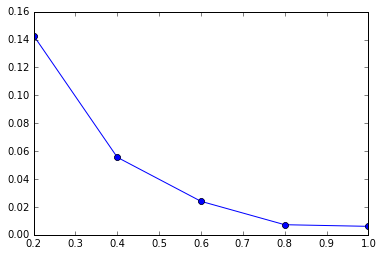

In [21]:
pr=PrecisionRecall(10)
pr.eval(irl)

0.047141315505872465

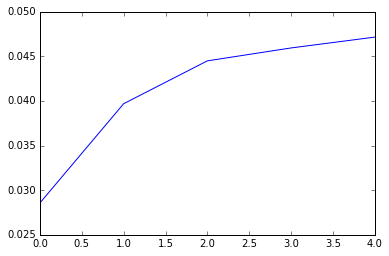

In [22]:
pm=PrecisionMean()
pm.eval(irl)

In [19]:
v=Vectoriel(weighter=WeighterTfTf())
v.construct()
v.WeightsNormfordocs()

<irmodel.Vectoriel instance at 0x10aaab098>

In [42]:
irl=IRList(gq.queries['58'],ok.getRanking(gq.queries['58'].text))

Calculate time is: 0.0228559970856


[0.020618556701030927,
 0.020618556701030927,
 0.020618556701030927,
 0.020100502512562814,
 0.01641025641025641,
 0.015050167224080268,
 0.0094552003601981096,
 0.0092148912642830809,
 0.0087363494539781598,
 0.0071581961345740875]

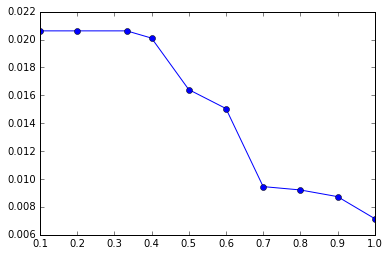

In [45]:
ir2=IRList(gq.queries['58'],v.getRanking(gq.queries['58'].text))
pr.eval(ir2)

In [47]:
from languagemodel import *
lm=LanguageModel(weighter=WeighterTfTf())

In [48]:
lm.construct()
lm.prepare()

<languagemodel.LanguageModel instance at 0x11eb32560>

In [49]:
ir3=IRList(gq.queries['58'],lm.getRanking(gq.queries['58'].text))

[0.5,
 0.5,
 0.15068493150684931,
 0.10619469026548672,
 0.061776061776061778,
 0.042056074766355138,
 0.011122881355932203,
 0.0093530787217459086,
 0.0087363494539781598,
 0.0071581961345740875]

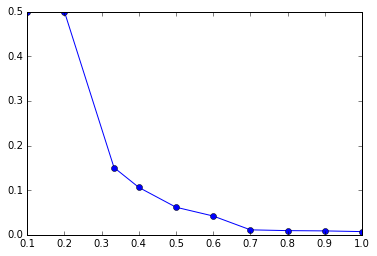

In [50]:
pr.eval(ir3)

In [20]:
irl=IRList(gq.queries['1'],v.getRanking(gq.queries['1'].text))

Calculate time is: 0.0155119895935


In [41]:
# irl.doc_score

[('1938', 17),
 ('1771', 16),
 ('1908', 15),
 ('2535', 14),
 ('2951', 14),
 ('1071', 13),
 ('1572', 12),
 ('2197', 11),
 ('2218', 11),
 ('1735', 11),
 ('1862', 11),
 ('4010', 11),
 ('2319', 10),
 ('3223', 10),
 ('2219', 10),
 ('1525', 10),
 ('3091', 10),
 ('4084', 10),
 ('3112', 10),
 ('3662', 10),
 ('2375', 10),
 ('2371', 10),
 ('3442', 10),
 ('1962', 10),
 ('3130', 10),
 ('3426', 10),
 ('4109', 10),
 ('2344', 10),
 ('3978', 10),
 ('2485', 10),
 ('3830', 9),
 ('3350', 9),
 ('3820', 9),
 ('2196', 9),
 ('3537', 9),
 ('1605', 9),
 ('1956', 9),
 ('3879', 9),
 ('678', 9),
 ('1827', 9),
 ('3461', 9),
 ('4134', 9),
 ('4048', 9),
 ('971', 9),
 ('2036', 9),
 ('3738', 9),
 ('3898', 9),
 ('3575', 9),
 ('1741', 9),
 ('2263', 8),
 ('3515', 8),
 ('1752', 8),
 ('3839', 8),
 ('3358', 8),
 ('2424', 8),
 ('1811', 8),
 ('3972', 8),
 ('1680', 8),
 ('3797', 8),
 ('2151', 8),
 ('1951', 8),
 ('796', 8),
 ('3950', 8),
 ('3644', 8),
 ('4147', 8),
 ('3674', 8),
 ('2380', 8),
 ('3250', 8),
 ('1901', 8),
 ('4135

In [ ]:
# pc.precision_recall
# pc=PrecisionRecall(nbLevels=10)
# pc.eval(irl)
# # pc.precision_recall
# np.shape(pc.eval(irl))
# pm=PrecisionMean()
# pm.eval(irl)
# v=Vectoriel(weighter=WeighterTf1(),normalised=False)
# v.construct()
# v.WeightsNormfordocs()
# irl=IRList(gq.queries['1'],v.getRanking(gq.queries['1'].text))

In [25]:
class EvalIRModel:
#     model: deifferent model of research on all the queries
#     evelu: different evaluation mesure "pr"=precision-recall or "pm"=precision moyenne
    def __init__(self,model,evalu="pr"):
        self.model=model
        self.evalu=evalu
    def eveluation (self,queries):
#         queries in created by querycacm
        results=[]

        for id_query in queries.keys():
            query=queries[id_query]
            if query.relevants !=None:
                self.model.getRanking(query.text)
                irlist=IRList(query,v.getRanking(query.text))
                nblevels=1
                if self.evalu=='pr':    
                    mesure = PrecisionRecall(12)
                    nblevels=mesure.nbLevels
                elif self.evalu=='pm':
                    mesure = PrecisionMean()   
                results.append(mesure.eval(irlist))

        if self.evalu=='pr':
            self.mean=np.mean(results,axis=0)
            self.std=np.std(results,axis=0)                                       
            
        else:
            self.mean=np.mean(results)
            self.std=np.std(results)
        return self.mean,self.std
            
            
                
#         mean and variance       

In [29]:
#exemple :
# er=EvalIRModel(v,'pr')
# er.eveluation(gq.queries)

In [30]:
from okapimodel import *

In [37]:
ok=OkapiModel(weighter=WeighterTfTf())
ok.construct()

In [38]:
ok.prepare()

<okapimodel.OkapiModel instance at 0x10ceaa368>

In [ ]:
pr.eval()

In [40]:
gq.queries['58'].relevants

['432',
 '536',
 '1293',
 '1344',
 '1398',
 '1411',
 '1420',
 '1445',
 '1619',
 '1629',
 '1631',
 '1691',
 '1709',
 '1812',
 '1944',
 '2098',
 '2115',
 '2122',
 '2123',
 '2249',
 '2349',
 '2395',
 '2634',
 '2636',
 '2719',
 '2731',
 '2825',
 '3159',
 '3166',
 '3167']

In [39]:
ok.getRanking(gq.queries['58'].text)

[('2314', 79.321637509172533),
 ('1709', 78.680565800534751),
 ('3138', 66.358208009190491),
 ('1411', 65.480914170616046),
 ('2904', 64.217216554559542),
 ('1433', 64.002657027944679),
 ('1695', 59.433656434033765),
 ('2098', 54.48252994033038),
 ('2670', 53.335955863291694),
 ('1066', 52.088332979326793),
 ('1779', 51.774072968823603),
 ('1171', 51.716421060055502),
 ('2395', 51.688960863388829),
 ('1944', 51.60019464920083),
 ('2145', 51.567582666742247),
 ('1816', 51.341663157030339),
 ('3049', 50.782048387033143),
 ('2135', 50.665346088263036),
 ('1344', 50.665346088263036),
 ('1398', 50.334143484204219),
 ('1423', 50.265517352106976),
 ('2795', 50.109087599235693),
 ('2389', 50.088704455336796),
 ('2994', 49.966923115781974),
 ('3067', 49.305918423059694),
 ('2167', 49.249063644396387),
 ('1885', 49.053474003879501),
 ('2634', 48.730565337853307),
 ('2245', 48.667132115344245),
 ('2951', 48.628847847932839),
 ('1946', 48.552468076162732),
 ('2849', 48.476338923864532),
 ('2217', 

In [ ]:
class LanguageModel(IRmodel):
    def __init__(self,lamda=0.5,weighter=Weighter()):
        self.lamda=lamda
        IRmodel.__init__(self,weighter)
    def getScores(self,query):
        scores={}
#         pmc pmd
        weights_query=self.weighter.getWeigtsForQuery(query)
        l_corpus=0
        for doc in self.weighter.index.docs.keys():
            tf_doc=self.weighter.index.getTfsForDoc(doc)
            l_corpus+=np.sum(tf_doc.values())
        for doc_id in self.weighter.index.docs.keys():
            tf_d = self.weighter.index.getTfsForDoc(doc_id)
            l_d=np.sum(tf_d.values())
            f_dq=0
            for term in weights_query.keys():
                if term in self.weighter.index.stems.keys():
                    tf_terminc=np.sum([ j for (k,j) in self.weighter.getDocWeightsForStem(term).values()[0]])
                    pmc=1.*tf_terminc/l_corpus
                    if term in tf_d:
                        f_dq+=weights_query[term]+np.log(self.lamda*tf_d[term]/l_d+(1.-self.lamda)*pmc)
                    else:
                        f_dq+=weights_query[term]+np.log((1.-self.lamda)*pmc)
            scores[doc_id]=f_dq
        self.Scores=scores
        return self.Scores

In [ ]:
lm=LanguageModel(weighter=WeighterTfTf())
lm.construct()


In [ ]:
# lm.getRanking('love')

In [ ]:
class OkapiModel(IRmodel):
    def __init__(self,k1=1,b=0.75,weighter=Weighter()):
        self.k1=k1
        self.b=b
        IRmodel.__init__(self,weighter)
    def CalLmean(self):
        L=0
        for doc_id in self.weighter.index.docs.keys():
            L+=np.sum(self.weighter.getDocWeightsForDoc(doc_id).values())
            self.L_mean=1.*L/len(self.weighter.index.docs)
        return self.L_mean
    def getScores(self,query):
        weights_query=self.weighter.getWeigtsForQuery(query)
        L_mean=620 
        N=len(self.weighter.index.docs)        
        
        self.scores={}
        for doc_id in self.weighter.index.docs.keys():
            tf_d=self.weighter.getDocWeightsForDoc(doc_id)
            L_d=np.sum(tf_d.values())
            f_dq=0.
            for t in weights_query.keys():
                 if t in self.weighter.index.stems.keys():
                        df_t=len(self.weighter.getDocWeightsForStem(t))  
                        idf=np.max([0,np.log(1.*(N-df_t+0.5)/(df_t+0.5))])
                        if t in tf_d.keys():
                            f_dq+=idf*((self.k1+1)*tf_d[t])/((1-self.b+self.b*L_d/L_mean)*self.k1+tf_d[t])
                        else:
                            f_dq+=0
            self.scores[doc_id]=f_dq
        return self.scores
                                               

In [ ]:
v.getRanking('love')

In [ ]:
# exemple:
Ok=OkapiModel(weighter=WeighterTfTf())
Ok.construct()


In [ ]:
Ok.getRanking('love')